# Image Classification Using TensorFlow

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### For GPU-enabled tensorflow

In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Acquire Datasets

In [9]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
#print(data_dir)

228813984/228813984 [==============================] - 11s 0us/step


In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


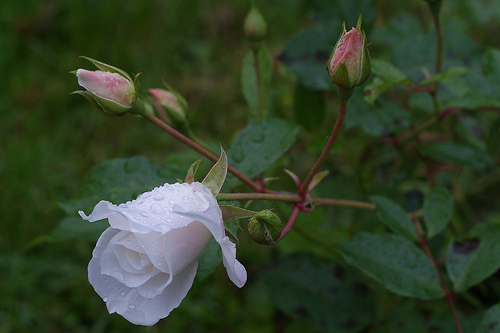

In [11]:
#Open some test images
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


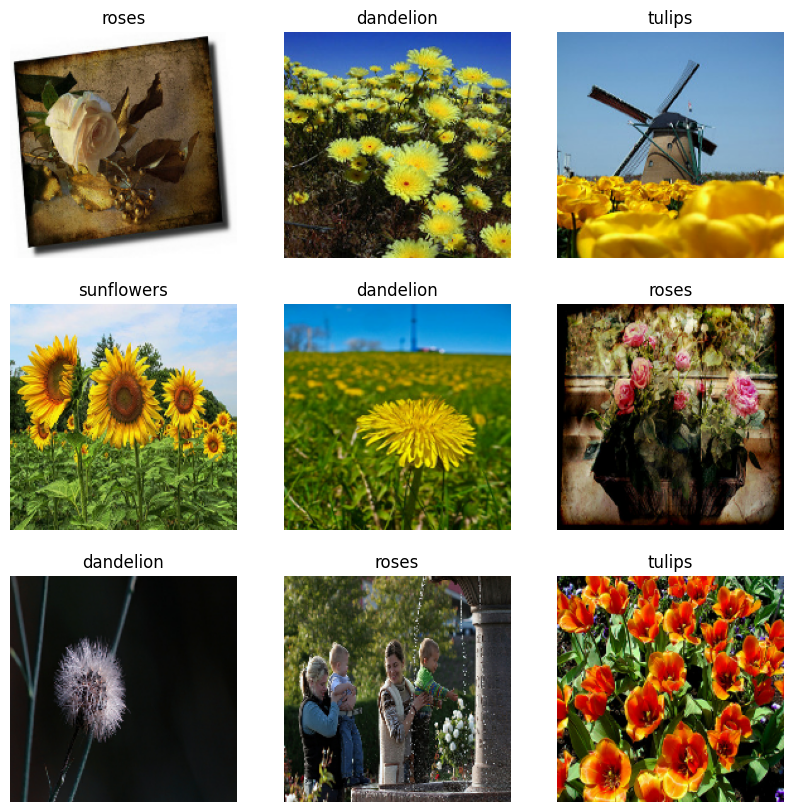

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


###### Configure the dataset for performance. Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

###### *Dataset.cache* keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
###### *Dataset.prefetch* overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
#Standardize the data to be in the [0,1] range by using the tf.keras.layers.Rescaling
normalization_layer = layers.Rescaling(1./255)

In [20]:
#Approach one, to apply onto the dataset using dataset.map
'''
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''

'\nnormalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\nfirst_image = image_batch[0]\n# Notice the pixel values are now in `[0,1]`.\nprint(np.min(first_image), np.max(first_image))\n'

In [36]:
num_classes = len(class_names)
#Approach 2, include the layer inside the model definition to simplify deployment
#Create our keras model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding ='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding ='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

###### For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
#model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [39]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2024-02-24 21:39:34.788003: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - 5s 26ms/step - loss: 1.3352 - accuracy: 0.4353 - val_loss: 1.0833 - val_accuracy: 0.5654
Epoch 2/10
92/92 [==============================] - 2s 17ms/step - loss: 0.9905 - accuracy: 0.6104 - val_loss: 1.0171 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 2s 16ms/step - loss: 0.7995 - accuracy: 0.7003 - val_loss: 1.0476 - val_accuracy: 0.6144
Epoch 4/10
92/92 [==============================] - 2s 16ms/step - loss: 0.5812 - accuracy: 0.7909 - val_loss: 1.1471 - val_accuracy: 0.6131
Epoch 5/10
92/92 [==============================] - 2s 16ms/step - loss: 0.3796 - accuracy: 0.8689 - val_loss: 1.1473 - val_accuracy: 0.6267
Epoch 6/10
92/92 [==============================] - 2s 16ms/step - loss: 0.2553 - accuracy: 0.9179 - val_loss: 1.4659 - val_accuracy: 0.6199
Epoch 7/10
92/92 [==============================] - 2s 17ms/step - loss: 0.1607 - accuracy: 0.9496 - val_loss: 1.4863 - val_accuracy: 0.6403
Epoch 8/10
92/92 [======

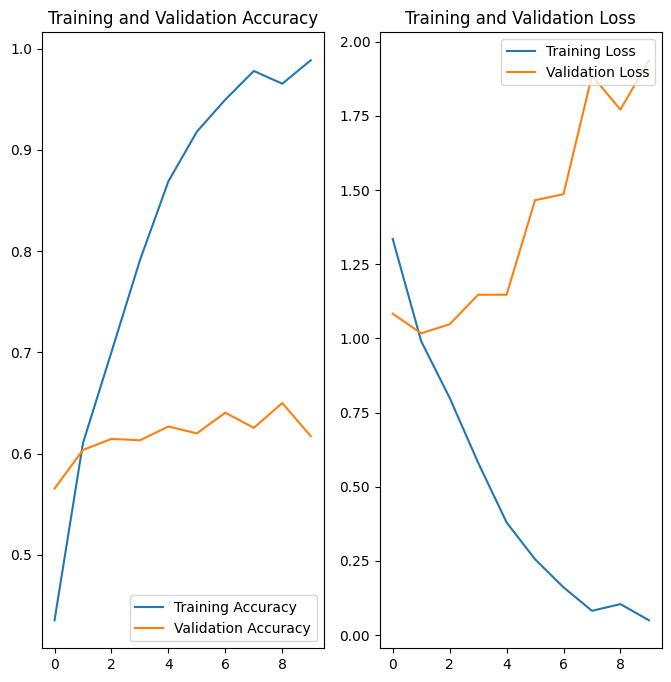

In [40]:
#Create plots of the loss and accuracy of training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

In [41]:
#Randomly flip the image and conduct rotations to generalize and prevent overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

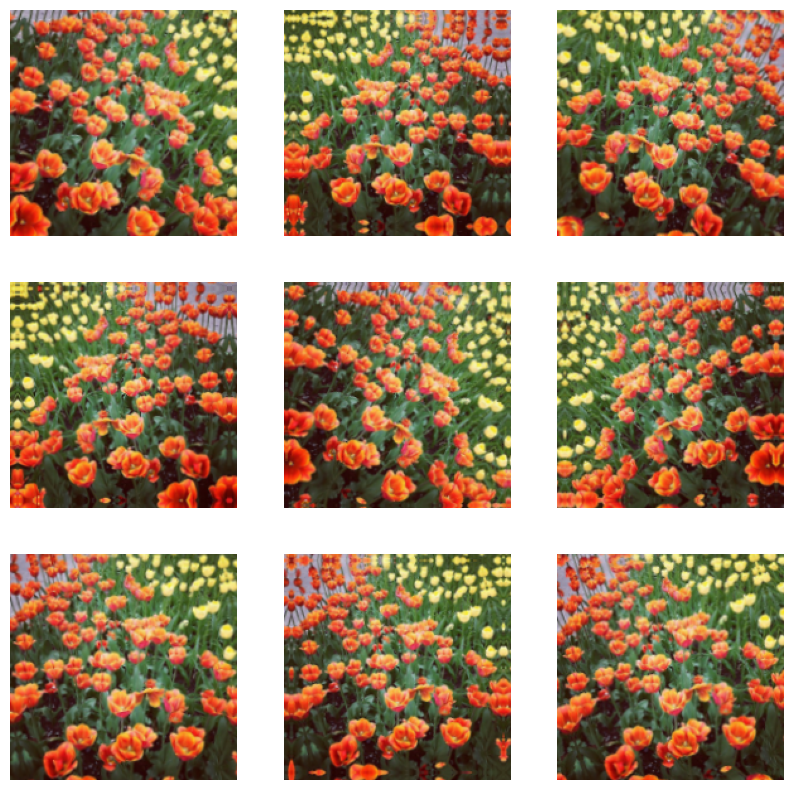

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [43]:
#Create our new keras model that uses data augmentation
model = Sequential([ 
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding ='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding ='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [47]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2024-02-24 21:41:27.034238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - 3s 22ms/step - loss: 1.4476 - accuracy: 0.3747 - val_loss: 1.1763 - val_accuracy: 0.5123
Epoch 2/15
92/92 [==============================] - 2s 21ms/step - loss: 1.1169 - accuracy: 0.5456 - val_loss: 1.0430 - val_accuracy: 0.5926
Epoch 3/15
92/92 [==============================] - 2s 20ms/step - loss: 1.0281 - accuracy: 0.6049 - val_loss: 1.0241 - val_accuracy: 0.5886
Epoch 4/15
92/92 [==============================] - 2s 21ms/step - loss: 0.9349 - accuracy: 0.6369 - val_loss: 0.9334 - val_accuracy: 0.6185
Epoch 5/15
92/92 [==============================] - 2s 20ms/step - loss: 0.8924 - accuracy: 0.6505 - val_loss: 0.9736 - val_accuracy: 0.6322
Epoch 6/15
92/92 [==============================] - 2s 20ms/step - loss: 0.8285 - accuracy: 0.6870 - val_loss: 0.9079 - val_accuracy: 0.6594
Epoch 7/15
92/92 [==============================] - 2s 20ms/step - loss: 0.8032 - accuracy: 0.6996 - val_loss: 0.8852 - val_accuracy: 0.6499
Epoch 8/15
92/92 [======

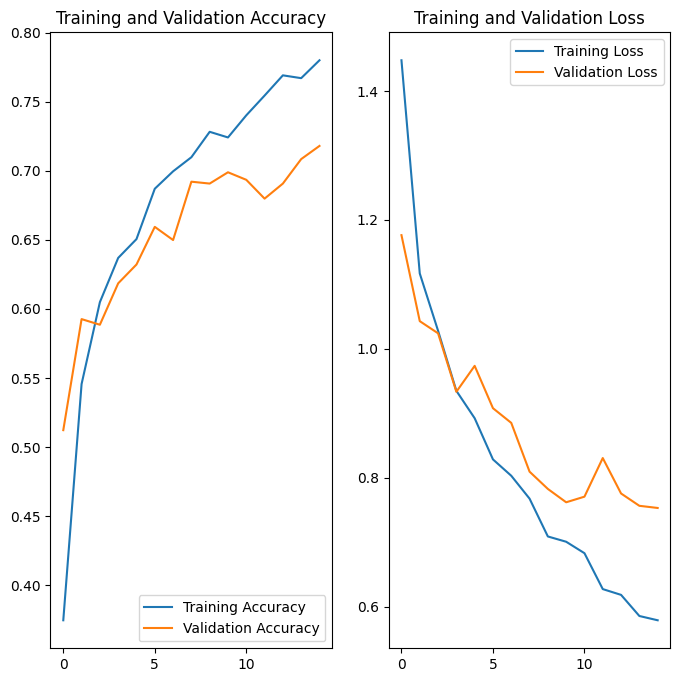

In [48]:
#Create plots of the loss and accuracy of training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

In [ ]:
|